## Autores: 
Blanco García, Gabriel: gabriel.blanco@cunef.edu   
Ferrín Meilá, Michelle: michelle.ferrin@cunef.edu

# Modelos: construcción, entrenamiento y selección.

<img src='https://storage.ning.com/topology/rest/1.0/file/get/2808372468?profile=original'>

En este notebook se prueban múltiples modelos de clasificación con el objetivo de ver cuál es el que mejor responde y genera mayor valor económico a la hora de predecir los sentimientos. Se construye un modelo base y calsificadores más avanzados. Se utilizan los hiperparámetros por defecto. El mejor de estos modelos será comparado con las redes neuronales qu se construirán en el siguiente notebook, y tomada la decisión del modelo ganador, se procederá a la optimización de sus hiperparámetros.

In [1]:
# Operaciones básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import pickle

# Procesamiento y modelado
from sklearn.feature_extraction.text import TfidfVectorizer # vectorizacion del texto
from sklearn.utils import shuffle # barajar los datos
from sklearn.pipeline import Pipeline # construicción de los pipelines

# Modelos
from sklearn.dummy import DummyClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Métricas
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# Nuestras funciones
%run ../src/operar_modelos.ipynb
%run ../src/plots_metricas.ipynb

## Importación y división de los datos

Cargamos los datos limpios

In [2]:
datos = pd.read_pickle('../data/clean/clean_data.sav')

In [3]:
datos.head()

,sentiment,review
0,1,one reviewer mentioned watching 1 oz episode y...
1,1,wonderful little production filming technique ...
2,1,thought wonderful way spend time hot summer we...
3,0,basically there family little boy jake think t...
4,1,petter matteis love time money visually stunni...


Antes de empezar a trabajar, se baraja el dataframe por si los datos pudiesen estar ordenados de alguna manera que anulase la aleatoriedad.  

In [6]:
np.random.seed(123)
datos = shuffle(datos)
datos.head()

,sentiment,review
47069,1,oneline summary hint good film true enjoy movi...
13768,0,despairing film dress actor furry rag place su...
2993,0,dueringer dorfer good standup comedian young u...
8856,1,surely gershwin family realizes one america gr...
964,1,may good old boy virginia confederate state am...


Efectuamos la división en tres tramos:
- __Train__: 60% de los datos. Para entrenar los modelos.
- __Validation__: 20% de los datos. Para calcular las métricas de la optimización de hiperparámetros y comparar contra el modelo sin optimizar
- __Test__: 20% para calcular las métricas, de los modelos sin optimizar y del modelo final ganador 

In [20]:
# Division
train, validation, test = np.split(datos.sample(frac=1, random_state=1234), 
                                   [int(0.6*len(datos)),
                                    int(0.8*len(datos))])

In [21]:
# Creación de los objetos con las variables y los target
# Tramo de entrenamiento 
X_train = train.review
y_train = train.sentiment

# Tramo de validacion 
X_validation = validation.review
y_validation = validation.sentiment

# Tramo de test
X_test = test.review
y_test = test.sentiment

Guardamos los datos en sus correspondientes carpetas

In [15]:
# Train en carpeta  train
X_train.to_pickle('../data/train/X_train.sav')
y_train.to_pickle('../data/train/y_train.sav')

# Validacion en carpeta validation
X_validation.to_pickle('../data/validation/X_validation.sav')
y_validation.to_pickle('../data/validation/y_validation.sav')

# Test en carpeta test
X_test.to_pickle('../data/test/X_test.sav')
y_test.to_pickle('../data/test/y_test.sav')

## Vectorización: de palabras a números

Los modelos de Machine Learning no entienden el texto del mismo modo que los seres humanos. Para poder utilizar texto en los modelos, es necesario vectorizarlos.

La __vectorización__ consiste en crear vectores a partir de palabras. Existen múltiples maneras de lograr este fin. La más simple es el one-hot encoding. Para aplicación a texto, este enfoque no es adecuado, porque sobredimensiona el problema.  
Otra forma es el conteo: representar cada palabra como un vector, cuyos elementos son la cuenta de veces que dicha palabra aparece en cada observación.  


<img src='https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/assets/atap_0402.png' width=500>



El problema de aplicar simplemente la cuenta es que palabras correspondientes al campo del texto, como en nuestro caso, _movie_ o _film_ (las más grandes en los wordcloud) obtienen valores altos, no porque realmente sean importantes en cada observacion, sino porque son palabras muy comunes que se emplean al hablar de películas.  

Para evitar este problema, utilizaremos el __TF-Idf__

### Tf-idf

TF-idf ("Term Frequency Inverse Document Frequency") es un algoritmo que evalúa la relevancia de una palabra para un documento en una colección de documentos. Lo interesante del TF-Idf es que logra contrarrestar la puntuación de palabras que aparecen muchas veces por el hecho de ser relativas a un campo.

$$ \textrm{tf-idf}(t) = \textrm{tf}(t, d) \times \textrm{idf}(t) $$

* $\textrm{tf}$ : Número de veces que el término $t$ aparece en el documento, $d$
* $\textrm{idf}$ : Frecuencia inversa de la palabra en el documento

El primer término, el tf, se calcula como el número de veces que aparece una palabra t, en un documento j, dividido entre el total de palabras de ese documento, d. En otras palabras, la proporción. $$\textrm{Term Frequency}(t, d) = \frac{t}{d}$$ 


El segundo término, idf, es el interesante. Se calcula como el logaritmo del cociente de N, número total de documentos y df, el número total de documentos en los que aprarece la palabra.

$$\textrm{idf}(t, N) = log\left(\frac{N}{{df_{t}}} \right)$$

De este modo: 

- Si la palabra está presente en muchos documentos, el cociente tenderá a 1, puesto que N sera aproximadamente igual a df. Si el resultado del cociente tiende a 1, el logaritmo del cociente tiende a 0, siendo exactamente 0 en el caso más extremo, que es aquel en el que N/df = 1, es decir, que la palabra está presente en __todos__ los documentos


 
- Análogamente, si la palabra aparece en un número de documentos menor que el total, el cociente será superior a 1, y el logartitmo del cociente se alejará de 0. 


$${w_{i, j}} = {tf_{i, j}} \times log \left(\frac{N}{df_{i}} \right)$$  
El resultado del logaritmo multiplica la proporción de dicha palabra (tf), penalizando aquellos casos en que la palabra aparece en muchos documentos, siendo el caso más extremo aquel en que la palabra está en todos los documentos, y la puntuación TF-Idf vale 0.


Inicializamos el vectorizador Tf-Idf. Este vectorizador, antes de construir los vectores, genera tokens a partir del texto, tal como se comentaba en el EDA, y por este motivo se excluye la tokenización del preprocesado, porque ya se realiza aquí al vectorizar

In [26]:
vectorizador_tfidf = TfidfVectorizer() 

### Modelo base

Todos los modelos constarán de dos elementos, el vectorizador y el clasificador. Construimos el modelo base

In [17]:
modelo_base = Pipeline(steps=[

    ('vectorizador', vectorizador_tfidf), 
    
    ('clasificador', DummyClassifier(strategy='most_frequent',
                                     random_state=1234))])

El modelo es el más simple, utiliza el valor más frecuente para predecir. Lo entrenamos y obtenemos su accuracy

In [18]:
modelo_base.fit(X_train, y_train)

Pipeline(steps=[('vectorizador', TfidfVectorizer()),
                ('clasificador',
                 DummyClassifier(random_state=1234, strategy='most_frequent'))])

In [19]:
modelo_base.score(X_test, y_test)

0.5013

Este será el modelo base que se utilizará como punto de comparación con los demás. Antes de proceder al entrenamiento del resto de modelos, definimos una función para calcular el coste o las ganancias asociadas a cada modelo, y así poder compararlos también en términos de negocio.

## Matriz de costes

Vamos a penalizar los falsos positivos duramente, porque consideramos que para este caso de uso, lo peor que puede suceder es que el modelo clasifique como positivas opiniones negativas. Es el peor caso, puesto  que se trataría de clientes insatisfechos que no reciben atención porque el modelo los clasifica como clientes felices. Para el ejemplo de las películas, se estaría clasificando como positivas reseñas que en realidad son negativas, creando la falsa sensación de que una película es exitosa, cuando en realidad los espectadores están descontentos con ella.

Definimos la función con los siguientes valores por defecto para cada tipo de clasificación:  

- __Verdaderos negativos__: 100. Son las opiniones negativas correctamente clasificadas. En la función tendrá  signo negativo, puesto que es una función de coste, y las opiniones correctamente clasificadas generan valor.  


- __Verdaderos positivos__: 50. Generan valor, pero menos que las negativas, que son el foco de nuestro modelo.   


- __Falsos positivos__: 300: Es la situación que queremos evitar a toda costa, así que la cuantificamos cara, el triple que los verdaderos negativos.  
  
  
- __Falsos negativos__: 80. Se trata de reviews que son positivas pero el modelo trata como negativas. Las penalizamos, puesto que se desperdician recursos que podrían aprovecharse con los clientes enfadados, aunque es un error menos grave que el falso positivo

Los números son arbitrarios y pueden modificarse según las peculiaridades de cada caso de uso. Para el presente, esta función servirá para poder cuantificar y comparar los modelos de manera económica.

In [22]:
def coste_modelo(modelo, 
                 coste_verdaderos_negativos=100,
                 coste_verdaderos_positivos=50,
                 coste_falsos_positivos=300,
                 coste_falsos_negativos=80):
    '''
    La función necesita el modelo, y que los objetos de test estén definidos. Los costes
    están puestos por defecto, pero pueden modificarse
    '''
    # Primero se obtiene la predicción
    y_pred = modelo.predict(X_test)
    
    # Con la predicción, se obtiene la matriz de confusión
    matriz_confusion = confusion_matrix(y_test, y_pred)
    
    # Se extrae cada uno de los tipos de clasificacion de la matriz
    verdaderos_negativos = matriz_confusion[0][0]
    falsos_positivos = matriz_confusion[0][1]
    verdaderos_positivos =  matriz_confusion[1][1]
    falsos_negativos = matriz_confusion[1][0]
    
    # Se calcula el coste con los valores de cada clasificacion
    coste = np.sum([(-1)*coste_verdaderos_negativos*verdaderos_negativos, # son perdidas que se evitan 
                    coste_falsos_negativos*falsos_negativos,
                    (-1)*coste_verdaderos_positivos*verdaderos_positivos, # son pérdidas que se evitan
                    coste_falsos_positivos*falsos_positivos])
    return coste

Definimos también una función para calcular la tasa de falsos positivos

In [28]:
def tasa_falsos_positivos(modelo):
    
    # Se obtiene la predicción
    y_pred = modelo.predict(X_test)
    
    # Se calcula la matriz  de confusión
    matriz_confusion = confusion_matrix(y_test, y_pred)
    
    # Se extaraen cada uno de los elementos necesarios para calcular la tasa
    falsos_positivos = matriz_confusion[0][1]
    verdaderos_negativos = matriz_confusion[0][0]
    
    # Tasa de falsos positivos = falsos positivos / (falsos positivos + verdaderos negativos)
    tasa_falsos_positivos = falsos_positivos / np.sum([falsos_positivos, 
                                                       verdaderos_negativos])
    
    return tasa_falsos_positivos

## Entrenamiento de modelos

Como el proceso es el mismo para todos los modelos, lo programamos en forma de loop, para recorrer una lista de modelos, generar cada modelo, entrenarlo, calcular sus métricas y guardarlo.

Cosntruimos la lista con todos los clasificadores. Aquí no se utilizan hiperparámetros, se comparan los modelos en su versión por defecto.

In [23]:
clasificadores =[
    
    LogisticRegression(),
    MultinomialNB(),
    KNeighborsClassifier(3),
    Perceptron(),
    PassiveAggressiveClassifier(),
    SGDClassifier(),
    DecisionTreeClassifier(),
    # SVC(), decidimos excluirlo, tiempo de cómputo desproporcionado frente al resto de modelos, generaba
    # muchos problemas
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
    
    ]

Construimos el bucle para realizar el mismo proceso para cada uno de los clasificadores en la lista definida

In [25]:
np.random.seed(123) # para poder reproducir los resultados

for clasificador in clasificadores:
    
    # Todos los modelos constarán de dos pasos
    modelo = Pipeline(steps=[
        
        # Primer paso: el texto pasa por el vectorizador Tf-Idf, que genera vectores a partir del texto
        ('vectorizador', vectorizador_tfidf), 
        
        # Segundo paso: los vectores entran al clasificador, que varía segun se itera 
        # sobre la lista de clasificadores
        ('clasificador', clasificador)]) 
    
    # Para cada clasificador de la lista, se ejecutan las siguientes operaciones:
    # Se entrena el modelo
    modelo = modelo.fit(X_train, y_train)
    
    # Se calculan diferntes métricas
    accuracy = modelo.score(X_test, y_test)
    
    y_pred = modelo.predict(X_test)
    
    f1 = f1_score(y_test, y_pred)
    
    tasa_falsos_positivos = tasa_falsos_positivos(modelo) *  100 
    
    # Se calculan las pérdidas/ganancias asociadas a cada modelo
    coste = coste_modelo(modelo) 
    
    # Se guarda cada modelo con su nombre en la carpeta de clasificadores, en modelos entrenados
    ruta = f'../models/trained_models/classifiers/{clasificador}.sav'
    guardar_modelo(modelo, ruta)
    
    # Se imprime cada clasificafor con sus métricas
    print(clasificador)
    print('Accuracy en test:', round(accuracy, 3))
    print('F1:', round(f1, 3))
    print('Tasa de falsos positivos:', round(tasa_falsos_positivos, 3), '%')
    
    # El cálculo de la matriz de coste: si el resultado es negativo, significa gananicas
    if (coste < 0):
        print('Ganancias de', (-1)*coste, '€') # si es negativo se le cambia el signo y se imprime como ganancias
    else:
        print('Pérdidas de', coste, '€')
    print('------------------------------------------------------')

LogisticRegression()
Accuracy en test: 0.89
F1: 0.891
Tasa de falsos positivos: 12.268 %
Ganancias de 441860 €
------------------------------------------------------
MultinomialNB()
Accuracy en test: 0.86
F1: 0.857
Tasa de falsos positivos: 11.829 %
Ganancias de 408670 €
------------------------------------------------------
KNeighborsClassifier(n_neighbors=3)
Accuracy en test: 0.76
F1: 0.775
Tasa de falsos positivos: 31.079 %
Ganancias de 17990 €
------------------------------------------------------
Perceptron()
Accuracy en test: 0.87
F1: 0.867
Tasa de falsos positivos: 11.49 %
Ganancias de 425870 €
------------------------------------------------------
PassiveAggressiveClassifier()
Accuracy en test: 0.878
F1: 0.879
Tasa de falsos positivos: 12.587 %
Ganancias de 422330 €
------------------------------------------------------
SGDClassifier()
Accuracy en test: 0.889
F1: 0.89
Tasa de falsos positivos: 12.627 %
Ganancias de 435440 €
------------------------------------------------------

Tal como se puede observar, el mejor modelo es la regresión logística, puesto que en términos económicos, es el modelo que más ganancias genera a la empresa. Además, presenta una tasa de falsos positivos muy baja, de las más bajas de entre todos los modelos, y los mejores valores de accuracy y F1. Este clasificador es candidato a ser el ganador, en cuyo caso pasaría a la parte de optimización de hiperparámetros. No obstante, antes de escoger este modelo, en el siguiente notebook se construyen algunas redes neuronales y se comparan los resultados con la logística, por si se consiguiese un modelo superior.

Podemos hacer una evaluación preliminar de la logística, pero no profundizamos en las métricas porque éstas se calcularan con el modelo ganador optimizado

Cargamos el modelo entrenados entrenado en la última sesión

In [3]:
logit = cargar_modelo('../models/trained_models/classifiers/LogisticRegression().sav')

Definimos una función para representar gráficamente la matriz de costes, a parte de la matriz de confusión.

In [82]:
def plot_matriz_coste(modelo, 
                          titulo='Matriz de coste',
                          coste_verdaderos_negativos=100,
                          coste_verdaderos_positivos=50,
                          coste_falsos_positivos=300,
                          coste_falsos_negativos=80,   
                          color='RdYlGn'):
    '''
    Función para representar la matrizde costes, con los costes de cada
    error por defecto
    '''
    prediccion = modelo.predict(X_test) # la predicción
    
    confusion = confusion_matrix(y_test, prediccion) # la matriz de confusión
    
    # Definimos los elementos que van a ir dentro del gráfico: texto y número
    etiquetas = ['Verdaderos negativos', 'Falsos positivos', 
                 'Falsos negativos', 'Verdaderos positivos']
    
    # Se aisla cada elemento para facilitar los calculos
    falsos_positivos = confusion[0][1]
    falsos_negativos = confusion[1][0]
    verdaderos_negativos = confusion[0][0]
    verdaderos_possitivos = confusion[1][1]
    
    # Se calculan los costes de cada clase
    coste_total_falsos_positivos = coste_falsos_positivos * falsos_positivos
    coste_total_falsos_negativos = coste_falsos_negativos * falsos_negativos
    coste_total_verdaderos_positivos = (-1) * coste_verdaderos_positivos * verdaderos_possitivos
    coste_total_verdaderos_negativos = (-1) * coste_verdaderos_negativos * verdaderos_negativos
    
    # Se almacenan en una lista
    costes = [coste_total_verdaderos_negativos, coste_total_falsos_positivos,
             coste_total_falsos_negativos, coste_total_verdaderos_positivos]
    
    # Formato a euros
    coste_euros = ['{:0.0f} €'.format(value) for value in costes]
    
    # Formateo de las etiquetas para poder plotearlas
    labels = [f'{v1}\n{v2}' for v1, v2 in
              zip(etiquetas, coste_euros)]
    
    labels = np.asarray(labels).reshape(2,2)
    
    # Y ahora el plot
    plt.subplots(figsize=(12, 7))
    
    sns.heatmap(confusion, annot=labels, fmt='', cmap=color)
    plt.title(titulo)
    plt.xlabel('Valor estimado')
    plt.ylabel('Valor real'); 

Representamos la matriz de confusión y la matriz de costes de la logística

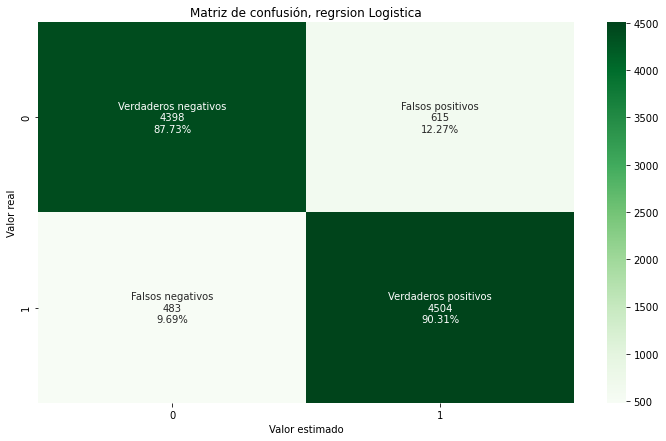

In [86]:
plot_matriz_confusion(logit, 'Matriz de confusión, regrsion Logistica')

La matriz de confusión está normalizada por filas, de tal modo que se muestran las distintas tasas (falsos positivos, falsos negativos...etc) Vemos tasas muy positivas en comparación al resto de modelos

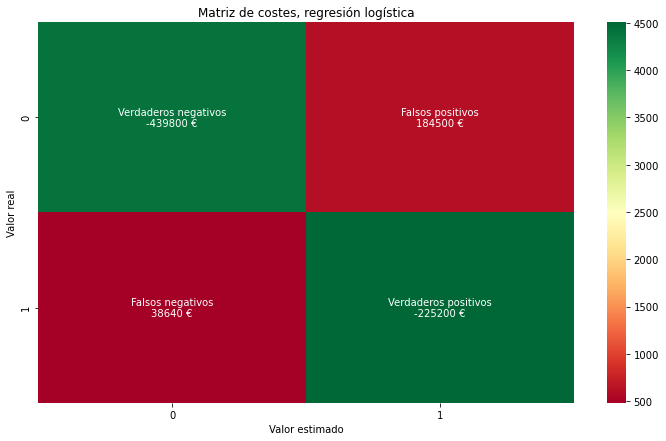

In [88]:
plot_matriz_coste(logit, 'Matriz de costes, regresión logística')

La matriz de costes complementa a la matriz de confusión en el sentido de que cuantifica de manera económica el valor de cada una de las clases. Vemos como el valor generado por los aciertos supera con creces el coste de los fallos, haciendo que el modelo sea rentable.

En el siguiente notebook se construirán diferentes redes neuronales que se compararán con la logística.